In [32]:
import pandas as pd
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import cv2
import os
import glob
import sys
import logging

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input 
from tensorflow.keras.applications import mobilenet_v2

from IPython import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# Import Photos

In [2]:
classes = ['apple','banana','flower','shell','stone'] 

base_path = 'data/'

In [3]:
# define an image data generator
data_gen = preprocessing.image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=mobilenet_v2.preprocess_input,
    # fill_mode='nearest',
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True, 
    # zoom_range=0.2,
    # shear_range=0.2    
)

In [4]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=500,  ## note: it's really images: 75 per category. this is mostly only working for models with transfer learning
        target_size=(224, 224)
)

Found 500 images belonging to 5 classes.


In [5]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((500, 224, 224, 3), (500, 5))

In [6]:
classes

['apple', 'banana', 'flower', 'shell', 'stone']

In [7]:
xtrain.dtype, ytrain.dtype

(dtype('float32'), dtype('float32'))

# Keras Sequential Model:

In [8]:
# Clear session and build model:
K.clear_session()

model = Sequential([
    Conv2D(filters = 20, kernel_size = (3,3), strides = (1,1), padding = "valid", activation = "relu" ,input_shape = (224,224,3)),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = "valid"),

    
    Conv2D(filters = 20, kernel_size = (3,3), strides = (1,1), padding = "valid", activation = "relu"),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = "valid"),
    
    Flatten(),
    
    #Fully connected layers:
    
    Dense(20,activation='relu'),
    Dropout(0.2),# - optional
    
    #Output layer:
    Dense(5 ,activation= "softmax")

    
])

In [9]:
# Check the summary:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 20)      560       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 20)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 20)      3620      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 20)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 58320)             0         
                                                                 
 dense (Dense)               (None, 20)                1

In [10]:
# Compile the model
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
# Early stopping:
early_stop = keras.callbacks.EarlyStopping(
    monitor='accuracy', #the thing we are monitoring
    min_delta=0.0005, #the minimum change in the quantity that we want for the model to train for another epoch
    patience=20, #number of epochs with no improvement needed for the model to stop
    verbose=1, #0 is silent, 1 means a message is displayed when something happens
    mode='auto'  
)

In [12]:
# Fit the model
history = model.fit(xtrain,ytrain,batch_size=40, epochs=100,validation_split=0.2, callbacks = [early_stop])

Epoch 1/100
10/10 [==============================] - 2s 187ms/step - loss: 1.4225 - accuracy: 0.4150 - val_loss: 0.9624 - val_accuracy: 0.6500
Epoch 2/100
10/10 [==============================] - 2s 174ms/step - loss: 0.8811 - accuracy: 0.6225 - val_loss: 0.6188 - val_accuracy: 0.8000
Epoch 3/100
10/10 [==============================] - 2s 173ms/step - loss: 0.6634 - accuracy: 0.7425 - val_loss: 0.5189 - val_accuracy: 0.8200
Epoch 4/100
10/10 [==============================] - 2s 173ms/step - loss: 0.5061 - accuracy: 0.7900 - val_loss: 0.3784 - val_accuracy: 0.8600
Epoch 5/100
10/10 [==============================] - 2s 173ms/step - loss: 0.3795 - accuracy: 0.8450 - val_loss: 0.2581 - val_accuracy: 0.9400
Epoch 6/100
10/10 [==============================] - 2s 173ms/step - loss: 0.3856 - accuracy: 0.8300 - val_loss: 0.3165 - val_accuracy: 0.9300
Epoch 7/100
10/10 [==============================] - 2s 173ms/step - loss: 0.2585 - accuracy: 0.9000 - val_loss: 0.2107 - val_accuracy: 0.9500

Epoch 58/100
10/10 [==============================] - 2s 173ms/step - loss: 0.0768 - accuracy: 0.9575 - val_loss: 0.0436 - val_accuracy: 0.9900
Epoch 59/100
10/10 [==============================] - 2s 173ms/step - loss: 0.0692 - accuracy: 0.9600 - val_loss: 0.0886 - val_accuracy: 0.9800
Epoch 60/100
10/10 [==============================] - 2s 173ms/step - loss: 0.0759 - accuracy: 0.9625 - val_loss: 0.1340 - val_accuracy: 0.9600
Epoch 61/100
10/10 [==============================] - 2s 173ms/step - loss: 0.0778 - accuracy: 0.9525 - val_loss: 0.0801 - val_accuracy: 0.9700
Epoch 62/100
10/10 [==============================] - 2s 173ms/step - loss: 0.0624 - accuracy: 0.9700 - val_loss: 0.0790 - val_accuracy: 0.9800
Epoch 63/100
10/10 [==============================] - 2s 173ms/step - loss: 0.0596 - accuracy: 0.9700 - val_loss: 0.0782 - val_accuracy: 0.9700
Epoch 64/100
10/10 [==============================] - 2s 173ms/step - loss: 0.0515 - accuracy: 0.9750 - val_loss: 0.0644 - val_accuracy:

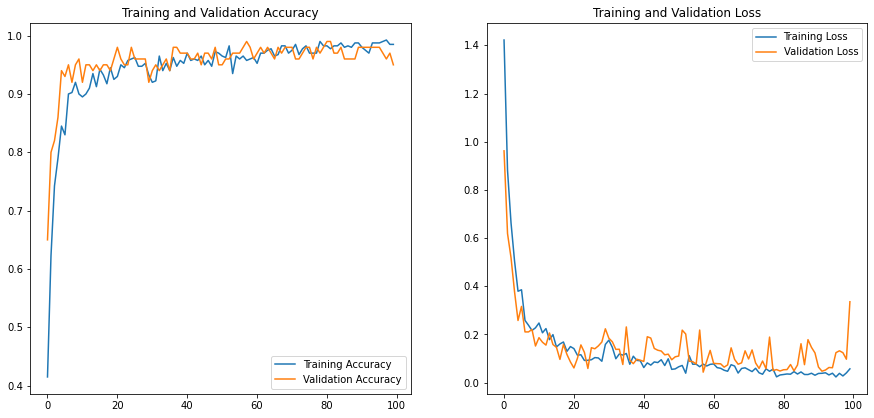

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')  
plt.plot(val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot( loss, label='Training Loss') 
plt.plot(val_loss, label='Validation Loss') 
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Make a prediction with Keras Sequential

In [14]:
#Pick a mystery image below to make a prediction:

img = image.load_img('data/mystery1.png')
#img = image.load_img('data/mystery2.png')
#img = image.load_img('data/mystery3.png')
#img = image.load_img('data/mystery4.png')
#img = image.load_img('data/mystery5.png')


In [15]:
img.size

(224, 224)

In [16]:
numpy_image = np.array(img)
numpy_image.shape

(224, 224, 3)

In [17]:
image = np.expand_dims(numpy_image, axis=0)
image.shape

(1, 224, 224, 3)

In [18]:
model.predict(image)[0]

array([0., 0., 0., 1., 0.], dtype=float32)

<BarContainer object of 5 artists>

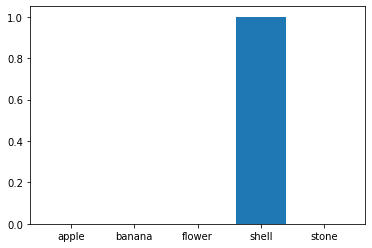

In [19]:
plt.bar(x = classes, height = model.predict(image)[0])

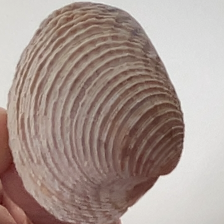

In [20]:
img

# Transfer Learning

**Create CNN Model**

In [21]:
base_model = mobilenet_v2.MobileNetV2(
    weights='imagenet', 
    alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # <------ !!!!! we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

In [22]:
#base_model.summary()

**Freeze the weights**

In [23]:
# freeze it!
base_model.trainable = False

In [24]:
#base_model.summary()

In [25]:
classes, len(classes)

(['apple', 'banana', 'flower', 'shell', 'stone'], 5)

In [26]:
model = keras.Sequential()
model.add(base_model)
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(classes), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
# have a look at the trainable and non-trainable params statistic
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_0.35_224 (Funct  (None, 1280)             410208    
 ional)                                                          
                                                                 
 dense_2 (Dense)             (None, 100)               128100    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 505       
                                                                 
Total params: 538,813
Trainable params: 128,605
Non-trainable params: 410,208
_________________________________________________________________


In [27]:
K.clear_session()

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

# observe the validation loss and stop when it does not improve after 20 iterations
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

model.fit(xtrain, ytrain, 
          epochs=200, 
          verbose=2,
          batch_size=100, 
          #callbacks=[callback],
          # use 20% of the data for validation
          validation_split=0.2)

Epoch 1/200
4/4 - 2s - loss: 1.6701 - categorical_accuracy: 0.3225 - val_loss: 0.6242 - val_categorical_accuracy: 0.8400 - 2s/epoch - 606ms/step
Epoch 2/200
4/4 - 1s - loss: 0.5453 - categorical_accuracy: 0.8275 - val_loss: 0.2169 - val_categorical_accuracy: 0.9700 - 880ms/epoch - 220ms/step
Epoch 3/200
4/4 - 1s - loss: 0.2674 - categorical_accuracy: 0.9300 - val_loss: 0.1139 - val_categorical_accuracy: 0.9700 - 870ms/epoch - 217ms/step
Epoch 4/200
4/4 - 1s - loss: 0.1387 - categorical_accuracy: 0.9700 - val_loss: 0.0681 - val_categorical_accuracy: 0.9900 - 864ms/epoch - 216ms/step
Epoch 5/200
4/4 - 1s - loss: 0.1004 - categorical_accuracy: 0.9750 - val_loss: 0.0460 - val_categorical_accuracy: 1.0000 - 865ms/epoch - 216ms/step
Epoch 6/200
4/4 - 1s - loss: 0.0679 - categorical_accuracy: 0.9850 - val_loss: 0.0399 - val_categorical_accuracy: 1.0000 - 866ms/epoch - 217ms/step
Epoch 7/200
4/4 - 1s - loss: 0.0717 - categorical_accuracy: 0.9775 - val_loss: 0.0263 - val_categorical_accuracy: 1

4/4 - 1s - loss: 0.0017 - categorical_accuracy: 1.0000 - val_loss: 0.0140 - val_categorical_accuracy: 0.9900 - 950ms/epoch - 237ms/step
Epoch 57/200
4/4 - 1s - loss: 0.0017 - categorical_accuracy: 1.0000 - val_loss: 0.0141 - val_categorical_accuracy: 0.9900 - 897ms/epoch - 224ms/step
Epoch 58/200
4/4 - 1s - loss: 0.0016 - categorical_accuracy: 1.0000 - val_loss: 0.0141 - val_categorical_accuracy: 0.9900 - 920ms/epoch - 230ms/step
Epoch 59/200
4/4 - 1s - loss: 0.0015 - categorical_accuracy: 1.0000 - val_loss: 0.0139 - val_categorical_accuracy: 0.9900 - 899ms/epoch - 225ms/step
Epoch 60/200
4/4 - 1s - loss: 0.0024 - categorical_accuracy: 1.0000 - val_loss: 0.0135 - val_categorical_accuracy: 0.9900 - 889ms/epoch - 222ms/step
Epoch 61/200
4/4 - 1s - loss: 0.0027 - categorical_accuracy: 1.0000 - val_loss: 0.0132 - val_categorical_accuracy: 0.9900 - 894ms/epoch - 223ms/step
Epoch 62/200
4/4 - 1s - loss: 0.0015 - categorical_accuracy: 1.0000 - val_loss: 0.0131 - val_categorical_accuracy: 0.99

Epoch 111/200
4/4 - 1s - loss: 5.3355e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0143 - val_categorical_accuracy: 0.9900 - 1s/epoch - 253ms/step
Epoch 112/200
4/4 - 1s - loss: 7.3444e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0143 - val_categorical_accuracy: 0.9900 - 979ms/epoch - 245ms/step
Epoch 113/200
4/4 - 1s - loss: 5.6177e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0142 - val_categorical_accuracy: 0.9900 - 1s/epoch - 250ms/step
Epoch 114/200
4/4 - 1s - loss: 6.5126e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0143 - val_categorical_accuracy: 0.9900 - 982ms/epoch - 245ms/step
Epoch 115/200
4/4 - 1s - loss: 5.2170e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0144 - val_categorical_accuracy: 0.9900 - 966ms/epoch - 242ms/step
Epoch 116/200
4/4 - 1s - loss: 4.2499e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0146 - val_categorical_accuracy: 0.9900 - 964ms/epoch - 241ms/step
Epoch 117/200
4/4 - 1s - loss: 3.7296e-04 - categorical_accuracy: 1.0000 - val_los

Epoch 165/200
4/4 - 1s - loss: 3.0623e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0150 - val_categorical_accuracy: 0.9900 - 999ms/epoch - 250ms/step
Epoch 166/200
4/4 - 1s - loss: 2.4110e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0148 - val_categorical_accuracy: 0.9900 - 1s/epoch - 256ms/step
Epoch 167/200
4/4 - 1s - loss: 2.4205e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0149 - val_categorical_accuracy: 0.9900 - 1s/epoch - 259ms/step
Epoch 168/200
4/4 - 1s - loss: 2.2605e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0150 - val_categorical_accuracy: 0.9900 - 1s/epoch - 253ms/step
Epoch 169/200
4/4 - 1s - loss: 2.5356e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0151 - val_categorical_accuracy: 0.9900 - 1s/epoch - 250ms/step
Epoch 170/200
4/4 - 1s - loss: 2.5729e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0152 - val_categorical_accuracy: 0.9900 - 1s/epoch - 251ms/step
Epoch 171/200
4/4 - 1s - loss: 1.5825e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0153

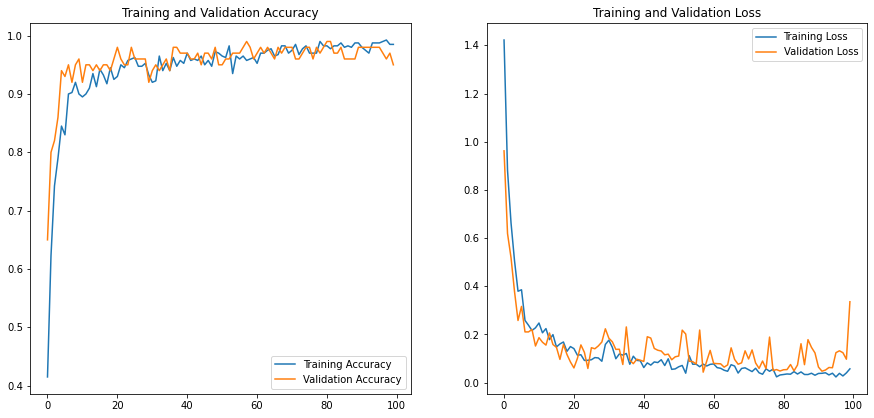

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')  
plt.plot(val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot( loss, label='Training Loss') 
plt.plot(val_loss, label='Validation Loss') 
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Make a Prediction using CNN

In [33]:
#img = image.load_img('data/mystery1.png')
#img = image.load_img('data/mystery2.png')
#img = image.load_img('data/mystery3.png')
img = image.load_img('data/mystery4.png')
#img = image.load_img('data/mystery5.png')

In [34]:
a = image.img_to_array(img)

In [35]:
a = np.expand_dims(a, axis = 0)

In [36]:
model.predict(a)

array([[2.1203335e-04, 2.7252143e-02, 8.5353494e-01, 1.1899866e-01,
        2.2871002e-06]], dtype=float32)

In [37]:
model.predict(a)[0].round(decimals = 3)

array([0.   , 0.027, 0.854, 0.119, 0.   ], dtype=float32)

<BarContainer object of 5 artists>

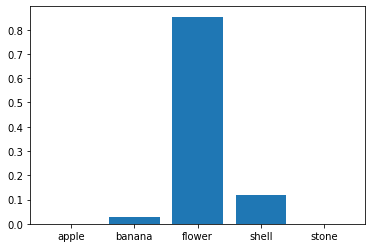

In [38]:
plt.bar(x = classes, height = model.predict(a)[0])

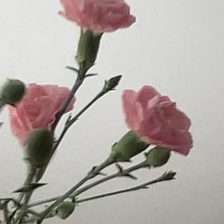

In [39]:
img

# Save your model for later

In [41]:
model.save('models/model5things.h5')